## Подключитесь к базе. Загрузите таблицы sql

In [116]:
!pip install skorch

In [117]:
import pandas as pd
from sqlalchemy import create_engine 
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import torch.nn as nn
import torch 
from skorch import NeuralNetClassifier
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [118]:
db_config = {
'user': 'user', # имя пользователя,
'pwd': 'pwd', # пароль,
'host': 'host',
'port': 'port', # порт подключения,
'db': 'db' # название базы данных,
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [119]:
engine = create_engine(connection_string) 

In [120]:
query = '''
SELECT *
FROM collisions
'''

collisions = pd.read_sql_query(query, con=engine) 

In [121]:
collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.00000,north,0.00000,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.00000,None,1.00000,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.00000,None,1.00000,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.00000,None,1.00000,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.00000,None,1.00000,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [122]:
query = '''
SELECT *
FROM parties
'''

parties = pd.read_sql_query(query, con=engine) 

In [123]:
parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.00000,had not been drinking,None,0.00000
1,23,3899454,2,road signs,0,7.00000,had not been drinking,None,0.00000
2,29,3899462,2,car,0,21.00000,had not been drinking,None,0.00000
3,31,3899465,2,road signs,0,24.00000,had not been drinking,None,0.00000
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.00000


In [124]:
query = '''
SELECT *
FROM vehicles 
'''

vehicles  = pd.read_sql_query(query, con=engine) 

In [125]:
vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.00000
1,1,3858022,1,sedan,auto,3.00000
2,1175712,5305030,1,sedan,auto,3.00000
3,1175717,5305033,3,sedan,auto,5.00000
4,1175722,5305034,2,sedan,auto,5.00000


In [126]:
query = '''
SELECT *
FROM case_ids
'''

case_ids = pd.read_sql_query(query, con=engine) 

In [127]:
case_ids.head()

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


In [128]:
query = '''
SELECT table_name FROM information_schema.tables 
'''
tables = pd.read_sql_query(query, con=engine) 

In [129]:
tables

,table_name
0,case_ids
1,collisions
2,parties
3,vehicles
4,pg_foreign_table
...,...
171,foreign_data_wrappers
172,foreign_server_options
173,foreign_servers
174,foreign_table_options


## Проведите первичное исследование таблиц

In [130]:
collisions.describe(include='all')

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
count,1400000,1400000,1400000,1400000.00000,1059358,1387781.00000,1392741,518779,1400000,1400000.00000,1391834,1372046,1388176,1393181,1386907,1388012,1391407,1391593,1400000,1387692
unique,1400000,538,58,NaN,4,NaN,7,3,5,NaN,5,23,7,9,4,8,5,4,1550,1440
top,4083072,1942,los angeles,NaN,south,NaN,clear,highway,small damage,NaN,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-10-13,15:00:00
freq,1,170335,433809,NaN,290513,NaN,1121048,416531,845771,NaN,1316453,438439,467109,891079,1242026,1346655,941950,916182,2069,9157
mean,NaN,NaN,NaN,660.71152,NaN,0.22491,NaN,NaN,NaN,1.96601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,11785.78506,NaN,0.41752,NaN,NaN,NaN,0.67245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.00000,NaN,0.00000,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,2.00000,NaN,0.00000,NaN,NaN,NaN,2.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,100.00000,NaN,0.00000,NaN,NaN,NaN,2.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,430.00000,NaN,0.00000,NaN,NaN,NaN,2.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
parties.describe(include='all')

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
count,2752408.00000,2752408,2752408.00000,2748786,2752408.00000,2347006.00000,2678453,432288,2240771.00000
unique,NaN,1400000,NaN,5,NaN,NaN,6,5,NaN
top,NaN,5196744,NaN,car,NaN,NaN,had not been drinking,G,NaN
freq,NaN,27,NaN,2469314,NaN,NaN,2124727,232901,NaN
mean,1376204.50000,NaN,1.59803,NaN,0.46800,38.74724,NaN,NaN,0.02045
std,794551.89420,NaN,0.72366,NaN,0.49898,16.37851,NaN,NaN,0.14154
min,1.00000,NaN,1.00000,NaN,0.00000,0.00000,NaN,NaN,0.00000
25%,688102.75000,NaN,1.00000,NaN,0.00000,25.00000,NaN,NaN,0.00000
50%,1376204.50000,NaN,1.00000,NaN,0.00000,36.00000,NaN,NaN,0.00000
75%,2064306.25000,NaN,2.00000,NaN,1.00000,50.00000,NaN,NaN,0.00000


In [132]:
vehicles.describe(include='all')

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
count,1021234.00000,1021234,1021234.00000,1021234,997575,996652.00000
unique,NaN,792642,NaN,5,2,NaN
top,NaN,5196744,NaN,sedan,auto,NaN
freq,NaN,27,NaN,488665,502243,NaN
mean,760162.79971,NaN,1.60951,NaN,NaN,5.13709
std,438619.36421,NaN,0.67909,NaN,NaN,3.11031
min,1.00000,NaN,1.00000,NaN,NaN,0.00000
25%,380694.25000,NaN,1.00000,NaN,NaN,3.00000
50%,761762.50000,NaN,2.00000,NaN,NaN,5.00000
75%,1141347.75000,NaN,2.00000,NaN,NaN,7.00000


In [133]:
case_ids.describe(include='all')

,case_id,db_year
count,1400000,1400000
unique,1400000,1
top,0081715,2021
freq,1,1400000


In [134]:
case_ids

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
...,...,...
1399995,5668365,2021
1399996,5668366,2021
1399997,5668367,2021
1399998,5668368,2021


### Вывод 
В case_id бесполезная информация, всего информаций о ДТП collisions count = 1400000, описание автомобиля меньше количества ДТП vehicles count = 1021234.

##  Проведите статистический анализ факторов ДТП

### Выясните, в какие месяцы происходит наибольшее количество аварий. Проанализируйте весь период наблюдений (таблица collisions).

In [135]:
query = '''
SELECT date_part('month', collision_date)::int, count(1)
FROM collisions
Group by date_part('month', collision_date)
order by count(1) desc
'''

collisions = pd.read_sql_query(query, con=engine) 

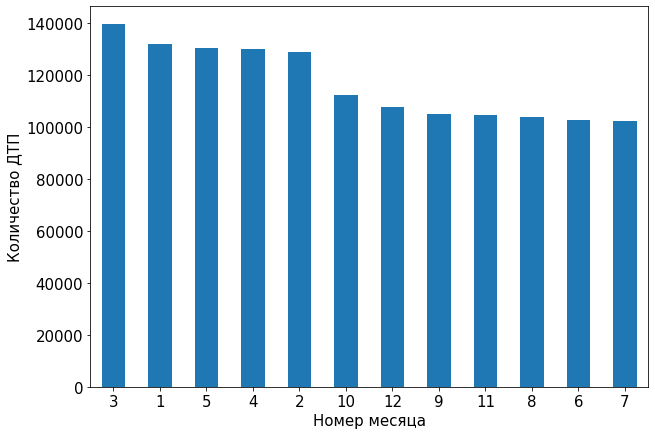

In [136]:
collisions.index = collisions['date_part']
collisions['count'].plot(kind='bar', figsize=(10,7), rot=0)
plt.xlabel('Номер месяца')
plt.ylabel('Количество ДТП')
plt.show()

Больше всего ДТП в марте, в первом полугодии больше дтп чем во втором.

### Скоро состоится первое совещание вашей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. Для этого вы должны создать подходящие аналитические задачи и поручить их решение коллегам. 

####  Создайте не менее шести задач для коллег. Опирайтесь на примеры и таблицы.

- Какая была погода в день января 2009 года с самым большим количиством ДТП за месяц.
- В какой месяц было меньше всего ДТП с участием автомобилей с типом кузова SEDAN?
- Вывести тип КПП который с самым большим количеством ДТП.
- Вывести самый большой возраст автомобиля попавшего в ДТП.
- Вывести самую большую сумму страховки автомобиля попавшего в ДТП.
- Какой тип кузова автомабиля чаще попадает в ДТП на перекрестке?

#### Пропишите порядок решения для двух задач из списка. Обязательное условие — решение этих задач должно включать связь не менее 2-х таблиц.

В какой месяц было меньше всего ДТП с участием автомобилей с типом кузова SEDAN?

In [137]:
query = '''
SELECT date_part('month', collision_date)::int, count(distinct(c.case_id))
FROM collisions c
left join vehicles v on c.case_id=v.case_id
where vehicle_type = 'sedan'
group by 1
order by 2
'''

query_1 = pd.read_sql_query(query, con=engine) 

In [138]:
query_1.index = query_1['date_part']

In [139]:
query_1 = query_1.drop('date_part', axis=1)

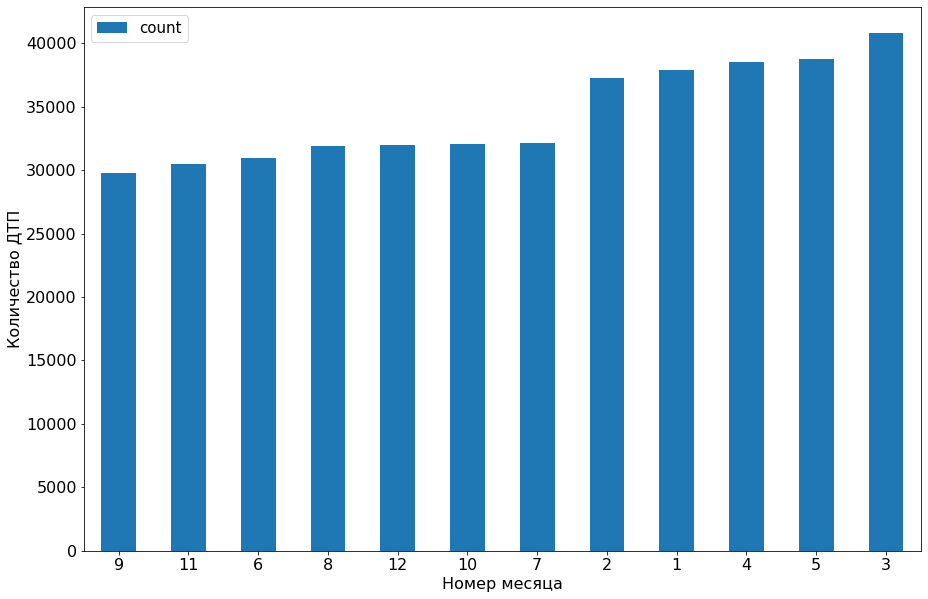

In [140]:
query_1.plot(kind='bar', figsize=(15,10), rot=0, fontsize=16)
plt.xlabel('Номер месяца', fontsize=16)
plt.ylabel('Количество ДТП', fontsize=16)
plt.show()

С января по май повышенный шанс на ДТП, в остальные месяцы меньше.

Какой тип кузова автомабиля чаще попадает в ДТП на перекрестке?

In [141]:
query = '''
SELECT vehicle_type, count(1)
FROM collisions c
left join vehicles v on c.case_id=v.case_id
where c.intersection = 1
group by 1
order by 2 desc
'''

query_2 = pd.read_sql_query(query, con=engine) 

In [142]:
query_2.index = query_2['vehicle_type']

In [143]:
query_2

,vehicle_type,count
vehicle_type,,
coupe,coupe,130359
sedan,sedan,111399
NaN,None,109536
minivan,minivan,16371
hatchback,hatchback,15490
other,other,283


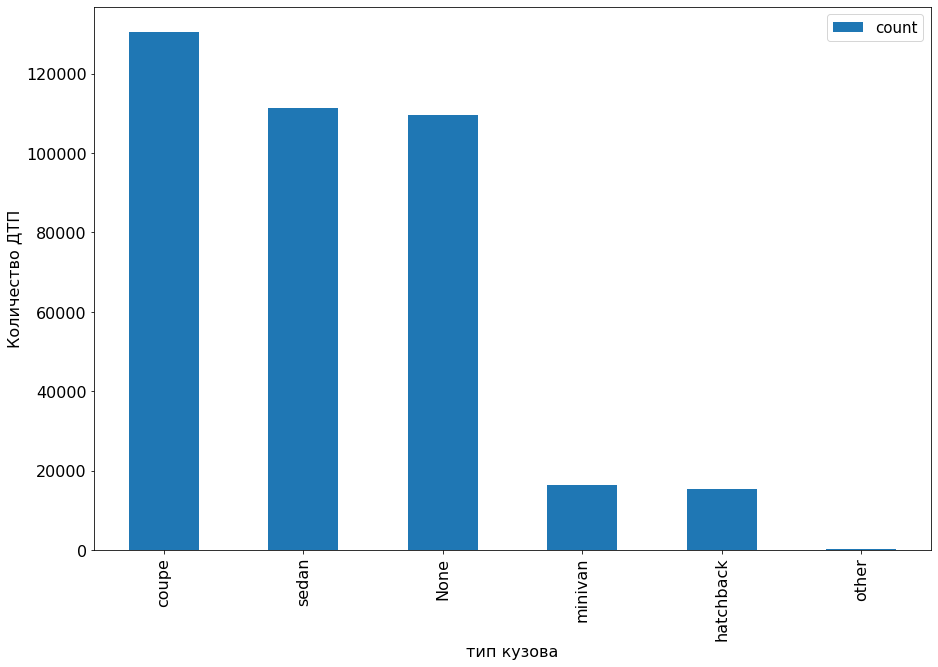

In [144]:
query_2.plot(kind='bar', figsize=(15,10), rot=90, fontsize=16)
plt.xlabel('тип кузова', fontsize=16)
plt.ylabel('Количество ДТП', fontsize=16)
plt.show()

Чаще всего в ДТП на перекрестке попадает автомобиль с типом coupe и sedan, ну и None но там любой тип мог быть.

## Создайте модель для оценки водительского риска

### Подготовьте набор данных на основе первичного предположения заказчика:
- Выберите тип виновника — только машина (car). **

In [145]:
query = '''
SELECT *
FROM parties
where party_type = 'car'
'''

parties = pd.read_sql_query(query, con=engine) 

- Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
- Для моделирования возьмите данные только за 2012 год.

In [146]:
query = '''
SELECT *
FROM collisions
where collision_damage <> 'scratch' and date_Trunc('year', collision_date)::date = '2012-01-01'
'''

collisions = pd.read_sql_query(query, con=engine) 

### Проведите первичный отбор факторов, необходимых для модели.

In [147]:
columms =['party_type',     # Тип участника происшествия. Таблица parties
          'party_sobriety', # Уровень трезвости виновника (точно может влиять) Таблица parties
          'weather_1',      # Погода (может влиять) Таблица collisions
          'road_surface',   # Состояние дороги (может влиять) Таблица collisions
          'lighting',       # Освещение (может влиять) Таблица collisions
          'location_type',  # Тип дороги (может влиять) Таблица collisions
          'road_condition_1',# Дорожное состояние (может влиять) Таблица collisions
          'control_device',
          'party_drug_physical',
          'vehicle_transmission'
          ]

In [148]:
full = collisions.merge(parties.merge(vehicles, how='left', on=['case_id','party_number']), how='inner', on='case_id')

In [149]:
pd.set_option('display.max_columns', 150)
full[full['case_id']=='5403029']

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,id_x,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id_y,vehicle_type,vehicle_transmission,vehicle_age
0,5403029,4313,santa clara,0.00000,None,1.00000,fog,None,fatal,3,vehicle code violation,automobile right of way,broadside,other motor vehicle,wet,normal,daylight,None,2012-01-03,07:29:00,2312509,1,car,1,25.00000,impairment unknown,G,NaN,1274766.00000,coupe,auto,4.00000
1,5403029,4313,santa clara,0.00000,None,1.00000,fog,None,fatal,3,vehicle code violation,automobile right of way,broadside,other motor vehicle,wet,normal,daylight,None,2012-01-03,07:29:00,2312510,2,car,0,18.00000,had not been drinking,None,NaN,NaN,NaN,NaN,NaN
2,5403029,4313,santa clara,0.00000,None,1.00000,fog,None,fatal,3,vehicle code violation,automobile right of way,broadside,other motor vehicle,wet,normal,daylight,None,2012-01-03,07:29:00,2312511,3,car,0,16.00000,had not been drinking,None,NaN,NaN,NaN,NaN,NaN


In [150]:
full.shape

(196837, 32)

### Проведите статистическое исследование отобранных факторов.

In [151]:
full[columms].isna().mean()

party_type             0.00000
party_sobriety         0.01842
weather_1              0.00332
road_surface           0.00647
lighting               0.00366
location_type          0.55620
road_condition_1       0.00581
control_device         0.00494
party_drug_physical    0.87224
vehicle_transmission   0.71860
dtype: float64

In [152]:
full['party_type'].value_counts()

car    196837
Name: party_type, dtype: int64

Все car бесполезный фактор можно убрать.

In [153]:
full['party_sobriety'] = full['party_sobriety'].fillna('Not Stated party_sobriety')
full['party_sobriety'].value_counts()

had not been drinking                     157684
impairment unknown                         20525
had been drinking, under influence         10270
Not Stated party_sobriety                   3625
had been drinking, impairment unknown       1706
not applicable                              1674
had been drinking, not under influence      1353
Name: party_sobriety, dtype: int64

In [154]:
full['weather_1'] = full['weather_1'].fillna('Not Stated weather_1')
full.loc[full['weather_1']=='other','weather_1'] = 'other weather_1'
full['weather_1'].value_counts()

clear                   157335
cloudy                   29497
raining                   8112
Not Stated weather_1       654
fog                        584
snowing                    433
other weather_1            175
wind                        47
Name: weather_1, dtype: int64

In [155]:
full['road_surface'] = full['road_surface'].fillna('Not Stated road_surface')
full['road_surface'].value_counts()

dry                        175564
wet                         18920
Not Stated road_surface      1273
snowy                         926
slippery                      154
Name: road_surface, dtype: int64

In [156]:
full['lighting'] = full['lighting'].fillna('Not Stated lighting')
full['lighting'].value_counts()

daylight                                   136370
dark with street lights                     38095
dark with no street lights                  14430
dusk or dawn                                 6775
Not Stated lighting                           721
dark with street lights not functioning       446
Name: lighting, dtype: int64

In [157]:
full['location_type'] = full['location_type'].fillna('Not Stated location_type')
full['location_type'].value_counts()

Not Stated location_type    109480
highway                      71914
ramp                         11526
intersection                  3917
Name: location_type, dtype: int64

In [158]:
full['road_condition_1'] = full['road_condition_1'].fillna('Not Stated road_condition_1')
full.loc[full['road_condition_1']=='other','road_condition_1'] = 'other road_condition_1'
full['road_condition_1'].value_counts()

normal                         189563
construction                     3355
Not Stated road_condition_1      1143
other road_condition_1            789
obstruction                       729
holes                             626
loose material                    310
reduced width                     217
flooded                           105
Name: road_condition_1, dtype: int64

In [159]:
full['control_device'] = full['control_device'].fillna('Not Stated control_device')
full['control_device'].value_counts()

none                         132665
functioning                   62639
Not Stated control_device       973
not functioning                 444
obscured                        116
Name: control_device, dtype: int64

In [160]:
full['party_drug_physical'] = full['party_drug_physical'].fillna('Not Stated party_drug_physical')
full['party_drug_physical'].value_counts()

Not Stated party_drug_physical    171689
G                                  20525
not applicable                      1674
under drug influence                1516
sleepy/fatigued                     1096
impairment - physical                337
Name: party_drug_physical, dtype: int64

In [161]:
full['vehicle_transmission'] = full['vehicle_transmission'].fillna('Not Stated vehicle_transmission')
full['vehicle_transmission'].value_counts()

Not Stated vehicle_transmission    141448
manual                              29318
auto                                26071
Name: vehicle_transmission, dtype: int64

In [162]:
full['at_fault'].isna().mean()

0.0

In [163]:
full['at_fault'].value_counts()

1    103047
0     93790
Name: at_fault, dtype: int64

In [166]:
full.vehicle_age.isna().mean()

0.7228468224978027

In [88]:
full = full[full['vehicle_age'] < 10]

In [89]:
columms =[#'party_type',     # Тип участника происшествия. Таблица parties
          'party_sobriety', # Уровень трезвости виновника (точно может влиять) Таблица parties
          'weather_1',      # Погода (может влиять) Таблица collisions
          'road_surface',   # Состояние дороги (может влиять) Таблица collisions
          'lighting',       # Освещение (может влиять) Таблица collisions
          'location_type',  # Тип дороги (может влиять) Таблица collisions
          'road_condition_1',# Дорожное состояние (может влиять) Таблица collisions
          'control_device',
          'party_drug_physical',
          'vehicle_transmission'
          ] 

In [90]:
train = pd.get_dummies(full['party_sobriety'])

In [91]:
train = train.merge(pd.get_dummies(full['weather_1']), left_index=True, right_index=True,how='left') \
             .merge(pd.get_dummies(full['road_surface']), left_index=True, right_index=True,how='left') \
             .merge(pd.get_dummies(full['lighting']), left_index=True, right_index=True,how='left') \
             .merge(pd.get_dummies(full['location_type']), left_index=True, right_index=True,how='left') \
             .merge(pd.get_dummies(full['road_condition_1']), left_index=True, right_index=True,how='left') \
             .merge(pd.get_dummies(full['control_device']), left_index=True, right_index=True,how='left') \
             .merge(pd.get_dummies(full['party_drug_physical']), left_index=True, right_index=True,how='left') \
             .merge(pd.get_dummies(full['vehicle_transmission']), left_index=True, right_index=True,how='left') 

In [92]:
X_train, X_test, y_train, test_y = train_test_split(train, full['at_fault'], test_size=0.25, random_state=1234)

## Найдите лучшую модель

### Catboost

In [93]:
cat_model = CatBoostClassifier()
# set up our search grid
param_grid = {'custom_loss':['F1'],
              "n_estimators": [200, 600],
              "verbose": [200],
              "learning_rate": [0.03, 0.1]}

# try out every combination of the above values
search = GridSearchCV(cat_model, param_grid, cv=4).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

0:	learn: 0.6890545	total: 166ms	remaining: 33.1s
199:	learn: 0.6174125	total: 1.64s	remaining: 0us
0:	learn: 0.6890640	total: 8.34ms	remaining: 1.66s
199:	learn: 0.6162162	total: 1.46s	remaining: 0us
0:	learn: 0.6891034	total: 7.85ms	remaining: 1.56s
199:	learn: 0.6159299	total: 1.47s	remaining: 0us
0:	learn: 0.6891897	total: 8.61ms	remaining: 1.71s
199:	learn: 0.6158926	total: 1.46s	remaining: 0us
0:	learn: 0.6890545	total: 8ms	remaining: 4.79s
200:	learn: 0.6173907	total: 1.51s	remaining: 2.99s
400:	learn: 0.6135918	total: 2.96s	remaining: 1.47s
599:	learn: 0.6103804	total: 4.42s	remaining: 0us
0:	learn: 0.6890640	total: 8.21ms	remaining: 4.92s
200:	learn: 0.6161812	total: 1.5s	remaining: 2.99s
400:	learn: 0.6121840	total: 2.96s	remaining: 1.47s
599:	learn: 0.6088561	total: 4.43s	remaining: 0us
0:	learn: 0.6891034	total: 8.11ms	remaining: 4.86s
200:	learn: 0.6159022	total: 1.48s	remaining: 2.93s
400:	learn: 0.6118330	total: 2.95s	remaining: 1.47s
599:	learn: 0.6085210	total: 4.45s	r

In [94]:
cat_model = CatBoostClassifier(learning_rate = search.best_params_["learning_rate"],
                              n_estimators  = search.best_params_["n_estimators"],
                              verbose       = search.best_params_["verbose"],
                              custom_loss  = search.best_params_["custom_loss"])

In [95]:
cat_model.fit(X_train,
              y_train,
#               cat_features=cat_features,
              eval_set=(X_test, test_y),
              plot=True)
prediction_catboost = cat_model.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6891086	test: 0.6892422	best: 0.6892422 (0)	total: 24.2ms	remaining: 4.81s
199:	learn: 0.6170519	test: 0.6201968	best: 0.6201968 (199)	total: 1.78s	remaining: 0us

bestTest = 0.620196812
bestIteration = 199



In [96]:
print(classification_report(test_y, prediction_catboost))

              precision    recall  f1-score   support

           0       0.58      0.82      0.68      6088
           1       0.71      0.43      0.54      6280

    accuracy                           0.62     12368
   macro avg       0.64      0.62      0.61     12368
weighted avg       0.65      0.62      0.61     12368



### LGBMRegressor

In [97]:
X_train.columns = [i.replace('-', ' ').replace('/', ' ').replace(',', '') for i in X_train.columns.values]
X_test.columns = [i.replace('-', ' ').replace('/', ' ').replace(',', '') for i in X_train.columns.values]

In [98]:
lgbm_model = LGBMClassifier()
# set up our search grid
param_grid = {"max_depth":    [12],
              "n_estimators": [200, 600],
              "learning_rate": [0.03, 0.07]}

# try out every combination of the above values
search = GridSearchCV(lgbm_model, param_grid, cv=4).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.03, 'max_depth': 12, 'n_estimators': 200}


In [99]:
lgbm_model = LGBMClassifier(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"])

In [100]:
lgbm_model.fit(X_train,
               y_train)

LGBMClassifier(learning_rate=0.03, max_depth=12, n_estimators=200)

In [101]:
prediction_lgbm = lgbm_model.predict(X_test)

In [102]:
print(classification_report(test_y, prediction_lgbm))

              precision    recall  f1-score   support

           0       0.58      0.81      0.68      6088
           1       0.71      0.43      0.54      6280

    accuracy                           0.62     12368
   macro avg       0.64      0.62      0.61     12368
weighted avg       0.65      0.62      0.61     12368



### Нейронка

In [103]:
class MyModule(nn.Module):
    def __init__(self, num_units=37, nonlin=F.relu):
        super(MyModule, self).__init__()

        self.dense0 = nn.Linear(53, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, 25)
        self.dense2 = nn.Linear(25, 11)
        self.output = nn.Linear(11, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = torch.tanh(self.dense1(X))
        X = torch.relu(self.dense2(X))
        X = F.softmax(self.output(X),dim=1)
        return X

In [104]:
net = NeuralNetClassifier(
    MyModule,


    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [105]:
params = {
    'lr': [0.1, .3, .5],
    'max_epochs': [30],
    'module__num_units': [50, 150],
}
gs = GridSearchCV(net, params, refit=1, cv=3)

gs.fit(X_train.values.astype(np.float32), y_train.values.astype(np.int64))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6898       0.5890        0.6848  0.5480
      2        0.6751       0.5905        0.6624  0.6190
      3        0.6560       0.5985        0.6438  0.5218
      4        0.6426       0.5963        0.6366  0.5110
      5        0.6357       0.6093        0.6322  0.5200
      6        0.6339       0.6109        0.6287  0.5060
      7        0.6322       0.6115        0.6280  0.5083
      8        0.6317       0.6113        0.6281  0.5124
      9        0.6304       0.6115        0.6265  0.5010
     10        0.6291       0.6113        0.6262  0.5050
     11        0.6285       0.6127        0.6274  0.5030
     12        0.6291       0.6151        0.6251  0.5040
     13        0.6283       0.6145        0.6240  0.5020
     14        0.6269       0.6169        0.6233  0.5210
     15        0.6272       0.6147        0.6228  0.5420
     16        0.6262       0.6

GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.MyModule'>,
),
             param_grid={'lr': [0.1, 0.3, 0.5], 'max_epochs': [30],
                         'module__num_units': [50, 150]},
             refit=1)

In [106]:
print(gs.best_score_, gs.best_params_)

0.6216209681881977 {'lr': 0.3, 'max_epochs': 30, 'module__num_units': 150}


In [107]:
print('-----------prediction_catboost:\n')
print(classification_report(test_y, prediction_catboost))
print('--------------------------------')
print('-----------prediction_lgbm:\n')
print(classification_report(test_y, prediction_lgbm))
print('--------------------------------')
print('-----------нейронка:\n')
print(classification_report(test_y, gs.predict(X_test.values.astype(np.float32))))
print('--------------------------------')

-----------prediction_catboost:

              precision    recall  f1-score   support

           0       0.58      0.82      0.68      6088
           1       0.71      0.43      0.54      6280

    accuracy                           0.62     12368
   macro avg       0.64      0.62      0.61     12368
weighted avg       0.65      0.62      0.61     12368

--------------------------------
-----------prediction_lgbm:

              precision    recall  f1-score   support

           0       0.58      0.81      0.68      6088
           1       0.71      0.43      0.54      6280

    accuracy                           0.62     12368
   macro avg       0.64      0.62      0.61     12368
weighted avg       0.65      0.62      0.61     12368

--------------------------------
-----------нейронка:

              precision    recall  f1-score   support

           0       0.59      0.78      0.67      6088
           1       0.69      0.47      0.56      6280

    accuracy                    

Больше всего машин попавших в ДТП находит и определяет нейронка f1-score = 0.56 для 1.

## Проверьте лучшую модель в работе

### Проведите графический анализ «Матрица ошибок». Выведите полноту и точность на график.

Confusion matrix, without normalization
[[4965 1123]
 [3571 2709]]


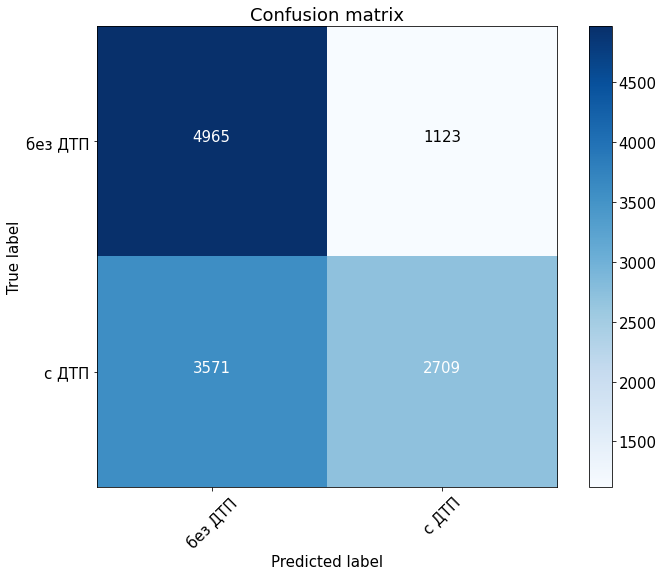

In [108]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(test_y, prediction_catboost)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['без ДТП', 'с ДТП'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

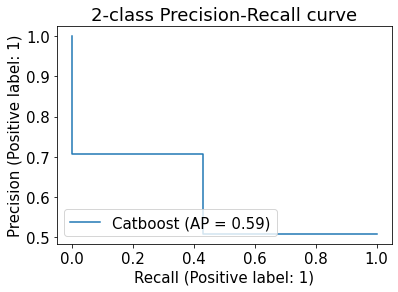

In [109]:
from sklearn.metrics import PrecisionRecallDisplay


display = PrecisionRecallDisplay.from_predictions(test_y, prediction_catboost, name="Catboost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

### Проанализируйте важность основных факторов, влияющих на вероятность ДТП.

In [110]:
df = pd.DataFrame((cat_model.feature_importances_)).T
df.columns = train.columns
df.T.sort_values(0,ascending=0)

,0
had not been drinking,35.90470
"had been drinking, under influence",26.69182
Not Stated party_drug_physical,5.54481
sleepy/fatigued,3.09815
Not Stated party_sobriety,2.99951
under drug influence,2.95399
none,2.65649
manual,2.34333
dry,2.12183
functioning,1.94540


### Для одного из выявленных важных факторов проведите дополнительное исследование:

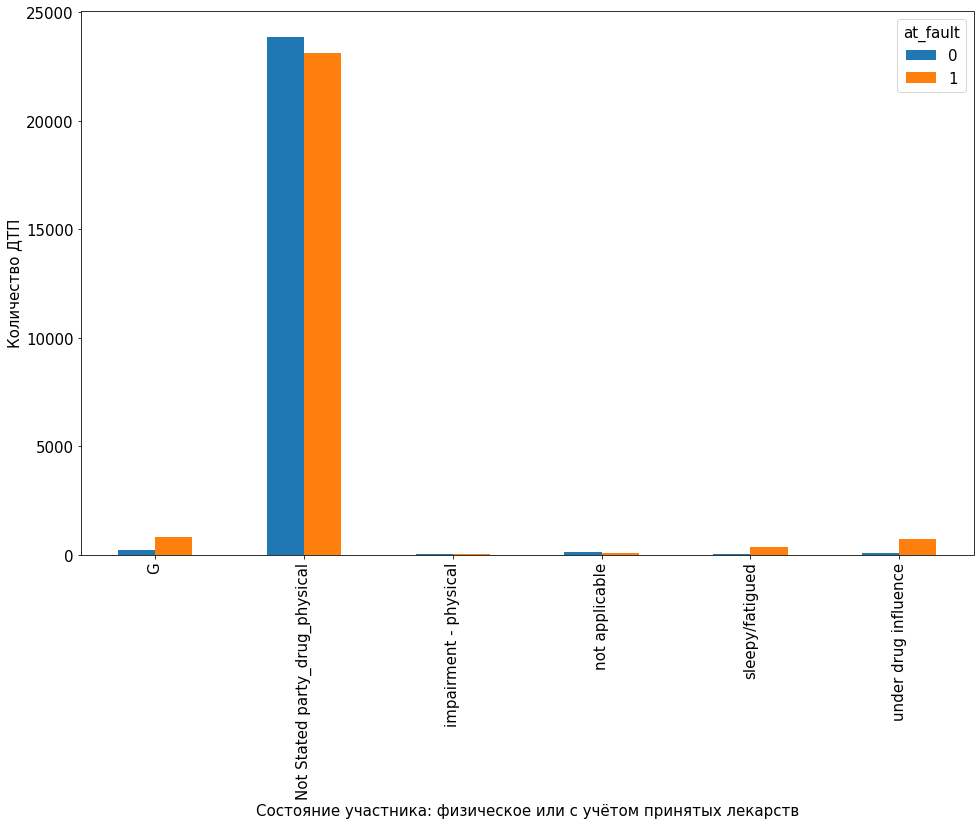

In [111]:
pd.crosstab(full['party_drug_physical'],full['at_fault']).plot(kind='bar',figsize=(16,10))
plt.xlabel('Состояние участника: физическое или с учётом принятых лекарств')
plt.ylabel('Количество ДТП')
plt.show()

Если Состояние участника это G — Impairment Unknown (Не известно) то чаще всего автомобиль попадет в ДТП.
Нужно оборудовать автомобиль тестером на состояние человека физическое или с учётом принятых лекарств.

## Выводы

- Лучшей моделью получился нейронка c лучше всех определяет и находит автомобиль с возможным ДТП.
- На данный момент определяет машины с ДТП меньше половины из всех возможных правильно, если улучшить метрики вполне адекватно можно использовать эту модель.
- Чтобы улучшить модель можно добавить данные о техническом состаянии автомобиля.